# **redis-feast-gcp**: 00 - Feature Store Intro

In this notebook, we will explore how a Feature Store works using Feast.

**This notebook assumes that you've already set up your Feature Store in GCP using the `setup` instructions in the README.**

![architecture](img/redis-feast-gcp-architecture.png)

## Fetching Historical Data

The Feast SDK allows us to pull historical data to generate a training dataset. In this cae, the data comes from BigQuery tables, but unbeknownst to the user.

To make things simpler, we use the [`DataFetcher`](utils/data_fetcher.py) class that wraps the Feast Python client.

In [1]:
from feature_store.repo import config
from feature_store.utils import (
    DataFetcher,
    storage
)

# Load Feast feature store
fs = storage.get_feature_store(
    config_path=config.REPO_CONFIG,
    bucket_name=config.BUCKET_NAME
)

# Load DataFetcher utility class
data_fetcher = DataFetcher(fs)

Feast is an open source project that collects anonymized error reporting and usage statistics. To opt out or learn more see https://docs.feast.dev/reference/usage


In [2]:
# The data fetcher class contains the list of input features to use for model training
print(data_fetcher.X_cols)

print(data_fetcher.y_col)

['lag_1_vaccine_interest', 'lag_2_vaccine_interest', 'lag_1_vaccine_intent', 'lag_2_vaccine_intent', 'lag_1_vaccine_safety', 'lag_2_vaccine_safety', 'lag_1_weekly_vaccinations_count', 'lag_2_weekly_vaccinations_count']
['weekly_vaccinations_count']


In [3]:
# Fetch historical training data with Feast
ds = data_fetcher.get_training_data(
    entity_query=f"""
        select
            state,
            date as event_timestamp
        from
            {config.BIGQUERY_DATASET_NAME}.{config.WEEKLY_VACCINATIONS_TABLE}
    """
)

# Clean up any nulls
ds.dropna(inplace=True)
ds.sort_values(['event_timestamp', 'state'], axis=0, inplace=True)

In [4]:
# Subset the data to the state of Virginia (in the US)
virginia = ds[ds.state == 'Virginia']

In [5]:
# Inspect part of the dataset for Virginia
virginia.head()

,state,event_timestamp,lag_1_vaccine_interest,lag_2_vaccine_interest,lag_1_vaccine_intent,lag_2_vaccine_intent,lag_1_vaccine_safety,lag_2_vaccine_safety,lag_1_weekly_vaccinations_count,lag_2_weekly_vaccinations_count,weekly_vaccinations_count
3267,Virginia,2021-01-25 00:00:00+00:00,62.549712,64.178025,22.662099,25.802051,9.102064,8.580120,152933,115553.0,329892.0
3331,Virginia,2021-02-01 00:00:00+00:00,59.771108,62.549712,23.881589,22.662099,9.060282,9.102064,329892,152933.0,278811.0
3279,Virginia,2021-02-08 00:00:00+00:00,71.490393,59.771108,35.214495,23.881589,11.884993,9.060282,278811,329892.0,266744.0
3251,Virginia,2021-02-15 00:00:00+00:00,67.818582,71.490393,34.463701,35.214495,12.675395,11.884993,266744,278811.0,318139.0
3268,Virginia,2021-02-22 00:00:00+00:00,72.135382,67.818582,34.295162,34.463701,14.205749,12.675395,318139,266744.0,344859.0


In [6]:
virginia.tail()

,state,event_timestamp,lag_1_vaccine_interest,lag_2_vaccine_interest,lag_1_vaccine_intent,lag_2_vaccine_intent,lag_1_vaccine_safety,lag_2_vaccine_safety,lag_1_weekly_vaccinations_count,lag_2_weekly_vaccinations_count,weekly_vaccinations_count
3304,Virginia,2023-01-02 00:00:00+00:00,10.72945,11.383411,1.831109,2.094199,1.352006,1.276527,46707,65773.0,46312.0
3295,Virginia,2023-01-09 00:00:00+00:00,10.72945,11.383411,1.831109,2.094199,1.352006,1.276527,46312,46707.0,45059.0
3242,Virginia,2023-01-16 00:00:00+00:00,10.72945,11.383411,1.831109,2.094199,1.352006,1.276527,45059,46312.0,37554.0
3243,Virginia,2023-01-23 00:00:00+00:00,10.72945,11.383411,1.831109,2.094199,1.352006,1.276527,37554,45059.0,27998.0
3339,Virginia,2023-01-30 00:00:00+00:00,10.72945,11.383411,1.831109,2.094199,1.352006,1.276527,27998,37554.0,6770.0


In [7]:
virginia.weekly_vaccinations_count.describe()

count       106.000000
mean     179285.452830
std      148843.919624
min        6770.000000
25%       71501.500000
50%      127141.000000
75%      259355.250000
max      644252.000000
Name: weekly_vaccinations_count, dtype: float64

2023-02-06 15:34:18,297:          font_manager.py:1633              _load_fontmanager(): generated new fontManager


<AxesSubplot: xlabel='lag_2_vaccine_interest', ylabel='weekly_vaccinations_count'>

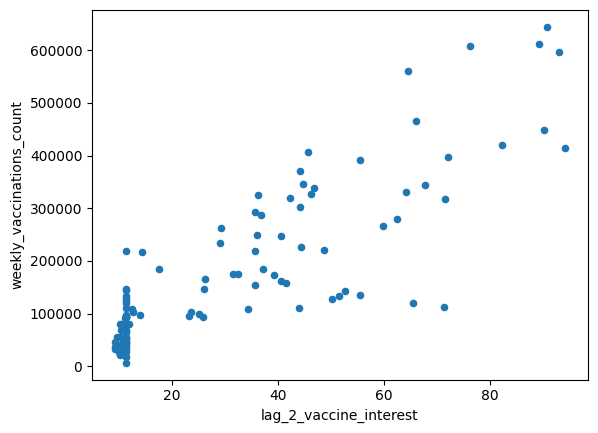

In [8]:
# Investigate trends across features for prediction weekly vaccinations count!
virginia.plot.scatter(y='weekly_vaccinations_count', x='lag_2_vaccine_interest')

## Low latency feature retrieval

To make a prediction in real-time, we need to do the following:

1. Fetch our features from Redis using the Feast client
2. Pass these features to our model
3. Return these predictions to the user

Here is an example pulling the latest features data from Redis (online store) for the state of *Virginia*.

In [9]:
# Fetch online feature
online_feature = data_fetcher.get_online_data(state="Virginia")

In [10]:
online_feature

,lag_1_vaccine_interest,lag_2_vaccine_interest,lag_1_vaccine_intent,lag_2_vaccine_intent,lag_1_vaccine_safety,lag_2_vaccine_safety,lag_1_weekly_vaccinations_count,lag_2_weekly_vaccinations_count
0,10.72945,11.383411,1.831109,2.094199,1.352006,1.276527,6770,27998


### Alternatives for Feature Retrieval
- Instead of using the Feast SDK (and our Data Fetcher class), you can also setup and use the [Python feature server](https://docs.feast.dev/reference/feature-servers/python-feature-server).
- If you need the best in class performance for feature retrieval and don't mind the extra setup, Feast also supports a [Go feature server](https://docs.feast.dev/reference/feature-servers/go-feature-server) that is much faster than standard Python.

If included in the project, you can run these HTTP (or gRPC) servers with `feast serve` command. The doc links above show how to set that up.